
### Alexandra Asinovskaya, 336091798

The task is to recreate the results of Partial Least Squares Regression for N prediction in oilseed rape leaf, and to add results of Pricipal Components Regression. The PLS and PCA are very similar, they are used for dimension reduction. But PCA is considered unsupervised method, bacause it doesn't taking into account relationships between X and Y, whereas PLS is considered supervised because it reduces dimentions taking both into account. PCA finds loadings that explain most of the variance using only values of X, and PLS is using both X and Y and finds loadings using also covariance of X and Y. 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
random.seed(10)

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv("Meanspectra.csv")
data_train = data[data["Dataset"]==1]
data_train = data_train.drop(['ID', 'Dataset'], axis=1)
data_test = data[data["Dataset"]==0]
data_test = data_test.drop(['ID', 'Dataset'], axis=1)

In [3]:
X_train = data_train.drop(["N Values"], axis=1)
y_train = data_train["N Values"]
X_test = data_test.drop(["N Values"], axis=1)
y_test = data_test["N Values"]

### PCR

In [4]:
pca = PCA()
regr = LinearRegression()

X_reduced_train = pca.fit_transform(scale(X_train))
n = len(X_reduced_train)

In [5]:
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
mse_n = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_root_mean_squared_error').mean()    
mse.append(mse_n)

# Calculate MSE using CV for the 127 principle components, adding one component at the time.
for i in np.arange(1, 20):
    mse_n = -1*model_selection.cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_root_mean_squared_error').mean()
    mse.append(mse_n)

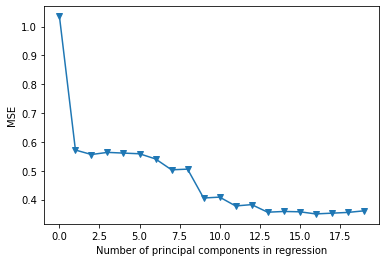

In [6]:
plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.show()

In [7]:
m = mse.index(min(mse))
X_reduced_test = pca.transform(scale(X_test))[:,:m+1]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:m+1], y_train)


# Prediction with train and test data
pred_train = regr.predict(X_reduced_train[:,:m+1])
rmse1_train = mean_squared_error(y_train, pred_train)
r2_1_train = r2_score(y_train, pred_train)
rpd1_train = np.std(y_train)/rmse1_train

pred_test = regr.predict(X_reduced_test)
rmse1_test = mean_squared_error(y_test, pred_test)
r2_1_test = r2_score(y_test, pred_test)
rpd1_test = np.std(y_test)/rmse1_test

### PLSRegression

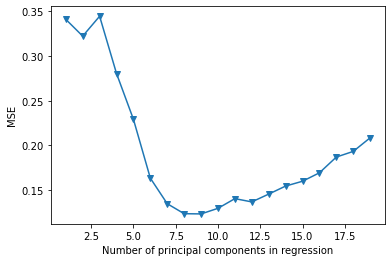

In [8]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.show()

In [9]:
m = mse.index(min(mse))

In [10]:
pls = PLSRegression(n_components=m)
pls.fit(scale(X_train), y_train)

pred_train = pls.predict(scale(X_train))
r2_2_train = r2_score(y_train, pred_train)
rmse2_train = math.sqrt(mean_squared_error(y_train, pred_train)) 
rpd2_train = np.std(y_train)/rmse2_train
pred_test = pls.predict(scale(X_test))
r2_2_test = r2_score(y_test, pred_test)
rmse2_test = math.sqrt(mean_squared_error(y_test, pred_test))
rpd2_test = np.std(y_test)/rmse2_test

In [11]:
d= pd.DataFrame(np.array([[r2_1_train, rmse1_train, rpd1_train, r2_1_test, rmse1_test, rpd1_test],
                         [r2_2_train, rmse2_train, rpd2_train, r2_2_test, rmse2_test, rpd2_test]]),
                columns=['R2_c', 'RMSE_c', 'RPD_c','R2_p', 'RMSE_p', 'RPD_p'])
d.index = ['PCA', 'PLS']

In [12]:
d

,R2_c,RMSE_c,RPD_c,R2_p,RMSE_p,RPD_p
PCA,0.915965,0.089146,11.553643,0.854906,0.141251,6.985204
PLS,0.925681,0.280782,3.668180,0.829114,0.407872,2.419061


As it written in a paper, a good model should yield high values of $RPD_C, ~RPD_P, ~R^2_C,~ R^2_P$, while low values of $RMSE_C, ~RMSE_P$, as well as a small difference between them. From that it like PCA performed slightly better than PLS. 